In [1]:
from KMedoids import KMedoids
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import os
from collections import defaultdict

# Check KMedoids

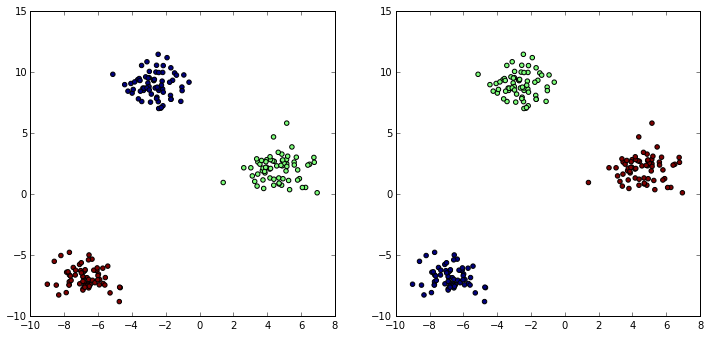

In [2]:
plt.figure(figsize=(12, 12))
n_samples = 200
X, y = make_blobs(n_samples=n_samples, random_state=42)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y)

#Transform X in a list of bag, each with one instance
Xbag = [x for x in X]
kmedoids = KMedoids(n_clusters=3, random_state=42)
hd_distances = kmedoids.compute_bags_distances(Xbag)
kmedoids.fit(Xbag, hd_distances)
y_pred = kmedoids.predict(Xbag)
plt.subplot(222)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

# Load training data

In [3]:
train_gnet = np.load('../data/models/features/googlenet/train_pool5_7x7_s1.npy')

In [4]:
train_pids = []
with open('../data/train.list', 'r') as lfile:
    for line in lfile:
        _, filename = os.path.split(line)
        pid_str, _ = os.path.splitext(filename)
        train_pids.append(int(pid_str))

In [5]:
pid_to_index = {pid: i for i, pid in enumerate(train_pids)}

In [7]:
assert(len(train_pids) == train_gnet.shape[0])

In [8]:
train_bid_to_labels_df = pd.read_csv('../data/raw/train.csv')
train_pid_to_bid_df = pd.read_csv('../data/raw/train_photo_to_biz_ids.csv')
train_bid_to_labels_df = train_bid_to_labels_df.dropna()

In [9]:
def binarize(labels_str, size=9):
    labels = [int(l) for l in labels_str.split()]
    binary_labels = np.zeros((9,))
    for l in labels:
        binary_labels[l] = 1
    return binary_labels

In [10]:
binarize('1 4 7')

array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.])

In [11]:
bid_to_labels_str = dict(zip(train_bid_to_labels_df.business_id, train_bid_to_labels_df['labels']))

In [12]:
bid_to_labels = {bid: binarize(labels) for bid, labels in bid_to_labels_str.items()}

In [13]:
train_pid_to_bid = dict(zip(train_pid_to_bid_df.photo_id, train_pid_to_bid_df.business_id))

In [14]:
bid_to_pids = defaultdict(list)
for pid, bid in train_pid_to_bid.items():
    if pid in pid_to_index and bid in bid_to_labels:
        bid_to_pids[bid].append(pid)

## Create bag-of-instances

In [15]:
X = []
for bid, pids in bid_to_pids.items():
    indices = np.array([pid_to_index[pid] for pid in pids])
    X.append(train_gnet[indices])

In [16]:
len(X)

1996

In [38]:
y = np.zeros((len(X), 9))
for i, (bid, _) in enumerate(bid_to_pids.items()):
    y[i] = bid_to_labels[bid]

In [39]:
y.shape

(1996L, 9L)

# Compute all bag-to-bag Haussdorf distances

In [17]:
kmedoids = KMedoids(n_clusters=10)

In [18]:
hd_distances = kmedoids.compute_bags_distances(X)

In [19]:
np.save('hd_distances.npy', hd_distances)

In [20]:
hd_distances.shape

(1996L, 1996L)

# Define training procedure on reduced data

In [25]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

In [40]:
def fit(X, y):
    n_labels = 9
    best_Cs = np.zeros((n_labels, ))
    best_f1s = np.zeros((n_labels, ))
    best_thresholds = np.zeros((n_labels, ))
    Cs = np.logspace(-4, 1, num=10)
    thresholds = np.linspace(0.2, 0.8, 50)

    for att in range(n_labels):
        for C in Cs:
            kfold = KFold(n = X.shape[0], n_folds=4, shuffle=True)

            f1s = [[] for i in range(100)]
            for train_index, test_index in kfold:
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index, att], y[test_index, att]

                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X_train)

                clf = LogisticRegression(C=C)
                clf.fit(X_train_s, y_train)

                X_test_s = scaler.transform(X_test)
                y_probas_test = clf.predict_proba(X_test_s)

                for i, threshold in enumerate(thresholds):
                    y_pred_test = np.where(y_probas_test[:, 1] > threshold, 1, 0)
                    f1s[i].append(f1_score(y_test, y_pred_test))

            for i, threshold in enumerate(thresholds):
                f1_mean = np.mean(f1s[i])
                if f1_mean > best_f1s[att]:
                    best_f1s[att] = f1_mean
                    best_Cs[att] = C
                    best_thresholds[att] = threshold

        print("Best for Attribute: {a}, C: {C}, T: {t}, F1-score: {f1}".format(a=att, C=best_Cs[att],\
                t=best_thresholds[att], f1=best_f1s[att]))
    return best_Cs, best_thresholds, best_f1s

In [41]:
seed = 42
np.random.seed(seed)
perm_bid = np.random.permutation(len(X))
train_ratio = 0.7
train_num = int(len(X) * train_ratio)
train_indices = perm_bid[:train_num]
val_indices = perm_bid[train_num:]

In [71]:
def subset(X, indices):
    return [X[i] for i in indices]

In [72]:
X_train = subset(X, train_indices)
X_val = subset(X, val_indices)
y_train = y[train_indices]
y_val = y[val_indices]

In [99]:
ks = [10, 50, 200, 400]

In [168]:
kmedoids = KMedoids(n_clusters=20, random_state=42)
kmedoids.fit(X_train, train_hd_distances)
medoids_ids = kmedoids._KMedoids__medoids_ids
medoids_id_original = train_indices[medoids_ids]
print medoids_ids.shape
Z_train = hd_distances[np.ix_(train_indices, medoids_id_original)]
Z_val = hd_distances[np.ix_(val_indices, medoids_id_original)]

(20L,)


In [169]:
from sklearn.preprocessing import StandardScaler

In [170]:
scaler = StandardScaler()

In [171]:
Z_train_s = scaler.fit_transform(Z_train)
Z_val_s = scaler.transform(Z_val)

In [172]:
from sklearn.ensemble import RandomForestClassifier

In [173]:
from sklearn.svm import SVC

In [174]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

In [176]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(Z_train_s, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(Z_val_s)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for f1
()


ValueError: bad input shape (1117L, 9L)

In [122]:
clf.fit(Z_train, y_train[:, 3])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [123]:
y_pred = clf.predict(Z_val)

In [124]:
f1_score(y_val[:, 3], y_pred)

0.5482233502538072

In [100]:
grid = []
for k in ks:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(X_train, train_hd_distances)
    medoids_ids = kmedoids._KMedoids__medoids_ids
    medoids_id_original = train_indices[medoids_ids]
    print medoids_ids.shape
    Z_train = hd_distances[np.ix_(train_indices, medoids_id_original)]
    Z_val = hd_distances[np.ix_(val_indices, medoids_id_original)]
    print Z_val.shape
    print("Transformed bag-of-instances to reduced sample")
    best_Cs, best_thresholds, best_f1s = fit(Z_train, y_train)
    grid.append((best_Cs, best_thresholds, best_f1s))

(10L,)
(599L, 10L)
Transformed bag-of-instances to reduced sample
Best for Attribute: 0, C: 0.00129154966501, T: 0.457142857143, F1-score: 0.592270235332
Best for Attribute: 1, C: 0.0599484250319, T: 0.408163265306, F1-score: 0.713240728326
Best for Attribute: 2, C: 0.215443469003, T: 0.359183673469, F1-score: 0.749112486063
Best for Attribute: 3, C: 0.00464158883361, T: 0.408163265306, F1-score: 0.665382035828
Best for Attribute: 4, C: 10.0, T: 0.297959183673, F1-score: 0.563052272428
Best for Attribute: 5, C: 0.774263682681, T: 0.420408163265, F1-score: 0.799536444699
Best for Attribute: 6, C: 0.215443469003, T: 0.481632653061, F1-score: 0.85104225082
Best for Attribute: 7, C: 2.78255940221, T: 0.261224489796, F1-score: 0.55637093898
Best for Attribute: 8, C: 0.016681005372, T: 0.408163265306, F1-score: 0.795819771695
(50L,)
(599L, 50L)
Transformed bag-of-instances to reduced sample
Best for Attribute: 0, C: 0.774263682681, T: 0.334693877551, F1-score: 0.6492812197
Best for Attribute